In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import random
import pickle
import cv2
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

In [2]:
from convautoencoder.convautoencoder import ConvAutoencoder

In [3]:
def build_unsupervised_dataset(data, labels, validLabel=1,
    anomalyLabel=3, contam=0.01, seed=42):
    # grab all indexes of the supplied class label that are *truly*
    # that particular label, then grab the indexes of the image
    # labels that will serve as our "anomalies"
    validIdxs = np.where(labels == validLabel)[0]
    anomalyIdxs = np.where(labels == anomalyLabel)[0]

    # randomly shuffle both sets of indexes
    random.shuffle(validIdxs)
    random.shuffle(anomalyIdxs)

    # compute the total number of anomaly data points to select
    i = int(len(validIdxs) * contam)
    anomalyIdxs = anomalyIdxs[:i]

    # use NumPy array indexing to extract both the valid images and
    # "anomlay" images
    validImages = data[validIdxs]
    anomalyImages = data[anomalyIdxs]

    # stack the valid images and anomaly images together to form a
    # single data matrix and then shuffle the rows
    images = np.vstack([validImages, anomalyImages])
    np.random.seed(seed)
    np.random.shuffle(images)

    # return the set of images
    return images

def visualize_predictions(decoded, gt, samples=10):
    # initialize our list of output images
    outputs = None

    # loop over our number of output samples
    for i in range(0, samples):
        # grab the original image and reconstructed image
        original = (gt[i] * 255).astype("uint8")
        recon = (decoded[i] * 255).astype("uint8")

        # stack the original and reconstructed image side-by-side
        output = np.hstack([original, recon])

        # if the outputs array is empty, initialize it as the current
        # side-by-side image display
        if outputs is None:
            outputs = output

        # otherwise, vertically stack the outputs
        else:
            outputs = np.vstack([outputs, output])

    # return the output images
    return outputs

In [4]:
# initialize the number of epochs to train for, initial learning rate,
# and batch size
EPOCHS = 20
INIT_LR = 1e-3
BS = 32

In [5]:
# load the MNIST dataset
print("[INFO] loading MNIST dataset...")
((trainX, trainY), (testX, testY)) = mnist.load_data()

# build our unsupervised dataset of images with a small amount of
# contamination (i.e., anomalies) added into it
print("[INFO] creating unsupervised dataset...")
images = build_unsupervised_dataset(trainX, trainY, validLabel=1,
    anomalyLabel=3, contam=0.01)

# add a channel dimension to every image in the dataset, then scale
# the pixel intensities to the range [0, 1]
images = np.expand_dims(images, axis=-1)
images = images.astype("float32") / 255.0

# construct the training and testing split
(trainX, testX) = train_test_split(images, test_size=0.2,
    random_state=42)

# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
(encoder, decoder, autoencoder) = ConvAutoencoder.build(28, 28, 1)
opt = tf.keras.optimizers.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
autoencoder.compile(loss="mse", optimizer=opt)

[INFO] loading MNIST dataset...
[INFO] creating unsupervised dataset...
[INFO] building autoencoder...


In [6]:
# train the convolutional autoencoder
H = autoencoder.fit(
    trainX, trainX,
    validation_data=(testX, testX),
    epochs=EPOCHS,
    batch_size=BS)

Epoch 1/20
171/171 [==============================] - 10s 55ms/step - loss: 0.0845 - val_loss: 0.0425
Epoch 2/20
171/171 [==============================] - 9s 55ms/step - loss: 0.0109 - val_loss: 0.0317
Epoch 3/20
171/171 [==============================] - 9s 54ms/step - loss: 0.0041 - val_loss: 0.0107
Epoch 4/20
171/171 [==============================] - 11s 65ms/step - loss: 0.0033 - val_loss: 0.0044
Epoch 5/20
171/171 [==============================] - 12s 68ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 6/20
171/171 [==============================] - 12s 73ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 7/20
171/171 [==============================] - 11s 67ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 8/20
171/171 [==============================] - 12s 68ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 9/20
171/171 [==============================] - 12s 71ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 10/20
171/171 [==============================] - 11s 64ms/step - loss: 0.0020 

In [7]:
# use the convolutional autoencoder to make predictions on the
# testing images, construct the visualization, and then save it
# to disk
print("[INFO] making predictions...")
decoded = autoencoder.predict(testX)
vis = visualize_predictions(decoded, testX)
cv2.imwrite('recon_vis.png', vis)

[INFO] making predictions...


True

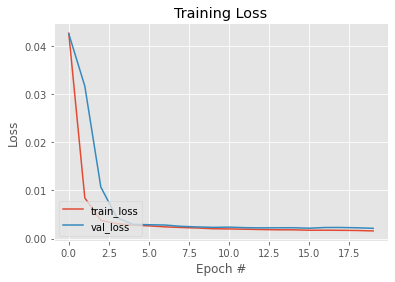

In [8]:
# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig('plot.png')

In [9]:
# make predictions on our image data and initialize our list of
# reconstruction errors
decoded = autoencoder.predict(images)
errors = []

# loop over all original images and their corresponding
# reconstructions
for (image, recon) in zip(images, decoded):
    # compute the mean squared error between the ground-truth image
    # and the reconstructed image, then add it to our list of errors
    mse = np.mean((image - recon) ** 2)
    errors.append(mse)

# compute the q-th quantile of the errors which serves as our
# threshold to identify anomalies -- any data point that our model
# reconstructed with > threshold error will be marked as an outlier
thresh = np.quantile(errors, 1)
idxs = np.where(np.array(errors) >= thresh)[0]
print("[INFO] mse threshold: {}".format(thresh))
print("[INFO] {} outliers found".format(len(idxs)))

# initialize the outputs array
outputs = None

[INFO] mse threshold: 0.05634688958525658
[INFO] 1 outliers found


In [ ]:
# loop over the indexes of images with a high mean squared error term
for i in idxs:
    # grab the original image and reconstructed image
    original = (images[i] * 255).astype("uint8")
    recon = (decoded[i] * 255).astype("uint8")

    # stack the original and reconstructed image side-by-side
    output = np.hstack([original, recon])

    # if the outputs array is empty, initialize it as the current
    # side-by-side image display
    if outputs is None:
        outputs = output

    # otherwise, vertically stack the outputs
    else:
        outputs = np.vstack([outputs, output])

# show the output visualization
cv2.imshow("Output", outputs)
cv2.waitKey(0)

In [ ]:
# serialize the image data to disk
print("[INFO] saving image data...")
f = open(args["dataset"], "wb")
f.write(pickle.dumps(images))
f.close()

# serialize the autoencoder model to disk
print("[INFO] saving autoencoder...")
autoencoder.save(args["model"], save_format="h5")